In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import  torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [73]:
import sys
import seaborn as sns
sys.path.append('/home/aggelos/PersonalProjects/ForecastingLib/')
from tsutils import SequenceSpliter
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [176]:
class TimeSeriesDataSet(Dataset):

    def __init__(self, datafile, features, lookback, feature_to_reconstruct):
        self.features = features
        self.feature_to_reconstruct = feature_to_reconstruct
        self.lookback = lookback

        df = pd.read_csv(datafile, usecols=self.features, delimiter='\t')
        df = df.rolling(lookback).mean().dropna()
        spliter = SequenceSpliter(lookback, 1)
        scaler = StandardScaler()
        scaled = scaler.fit_transform(df)
        df.iloc[:, :] = scaled
        X, _ = spliter.fit_transform(df.values)
        X = np.swapaxes(X, 1,2)
        self.target_idx = df.columns.get_loc(self.feature_to_reconstruct)
        self.dataset = torch.Tensor(X)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        return torch.Tensor(self.dataset[item])


workers = 4

batch_size = 128

lookback = 128

noise_size = 10

num_epochs = 2

lr = 0.0002

beta1 = 0.5

features = ['voltage [V]',
            'acceleration (actual) [m/(s*s)]',
            'tractive effort (actual) [kN]',
            'track-earth voltage [V]',
            'speed (actual) [km/h]',
            'current [A]',
            'energy balance [kWh]',
            'way (actual) [km]',
            'line and running resistance [kN]',
            'train configuration [1]',
            'energy input [kWh]',
            'train configuration [1]',
            'usable braking energy [kWh]',
            'used braking energy [kWh]'
            ]

nb_features = len(features)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = TimeSeriesDataSet("~/Downloads/simu_Elbas/7h33NO/7hnz0038.xls",
                            lookback=lookback,
                            features=features,
                            feature_to_reconstruct='voltage [V]')

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=workers, shuffle=True)

validation_dataset = TimeSeriesDataSet("~/Downloads/simu_Elbas/7h33NO/7hnz0040.xls",
                            lookback=lookback,
                            features=features,
                            feature_to_reconstruct='voltage [V]')

validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=workers, shuffle=True)


In [197]:
class Encoder(nn.Module):
    """This is the encoder part of the autoencoder"""
    
    def __init__(self, lookback):
        super().__init__()
        self.lookback = lookback
        self.dilations = [2**i for i in range(1,int(np.log2(lookback/2)))]
        self.conv1 = nn.Conv1d(13, self.lookback, kernel_size=3, stride=1, padding=1)
        self.layers = nn.ModuleList([])
        i=2
        for dilation in self.dilations:
            self.layers.append(nn.Conv1d(self.lookback//(i//2), self.lookback//i, kernel_size=3, stride=2, dilation=dilation, padding=dilation))
            i *= 2
        self.activation = nn.ReLU()

    
    def forward(self, x):
        x = self.activation(self.conv1(x))
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)

        return x
        

In [203]:
class Decoder(nn.Module):
    def __init__(self, lookback):
        """The decoder part of the autoencoder """
        
        super().__init__()
        self.layers = nn.ModuleList([])
        in_channels = 0
        i=1
        while in_channels != lookback//2:
            in_channels = i*4
            self.layers.append(nn.ConvTranspose1d(in_channels, 2*in_channels,kernel_size=in_channels, stride=1))
            i *= 2
        self.conv6 = nn.ConvTranspose1d(lookback, 13, 8, stride=1, padding=1)
        self.activation = nn.LeakyReLU()

    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
        x = self.conv6(x)
        return x

In [264]:
class AE(nn.Module):
    def __init__(self, lookback):
        super().__init__()
        self.encoder = Encoder(lookback)
        self.decoder = Decoder(lookback)
    def forward(self, x):
        code = self.encoder(x)
        self.code = code
        noisy_code = code + torch.randn(code.shape)
        reconstructed = self.decoder(code)
        return reconstructed

In [265]:
ae = AE(lookback)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters())
history_train_loss = []
history_val_loss = []
dataloaders = {'train': train_dataloader,
              'validation': validation_dataloader}

In [293]:
for epoch in tqdm(range(10)):
    for mode, dataloader in dataloaders.items():
        for batch in dataloader:
                if mode == 'train':
                    ae.train()
                    optimizer.zero_grad()
                    reconstructed = ae(batch)
                    train_loss = criterion(reconstructed, batch)
                    train_loss.backward()
                    optimizer.step()
                    history_train_loss.append(train_loss.item())

                else:
                    ae.eval()
                    reconstructed = ae(batch)
                    val_loss = criterion(reconstructed, batch)
                    history_val_loss.append(val_loss.item())
    if epoch%3 == 0:
        print(f"Epoch: {epoch+1}, Train_Loss: {train_loss.item()}, Val_loss: {val_loss.item()}")
            








  0%|          | 0/10 [00:00<?, ?it/s]





 10%|█         | 1/10 [00:07<01:07,  7.48s/it]

Epoch: 1, Train_Loss: 0.09971117228269577, Val_loss: 0.07380595803260803








 20%|██        | 2/10 [00:14<00:59,  7.47s/it]





 30%|███       | 3/10 [00:22<00:52,  7.46s/it]





 40%|████      | 4/10 [00:29<00:45,  7.51s/it]

Epoch: 4, Train_Loss: 0.062041107565164566, Val_loss: 0.11437828838825226








 50%|█████     | 5/10 [00:37<00:37,  7.48s/it]





 60%|██████    | 6/10 [00:45<00:30,  7.55s/it]





 70%|███████   | 7/10 [00:52<00:22,  7.50s/it]

Epoch: 7, Train_Loss: 0.10057444125413895, Val_loss: 0.1446027010679245








 80%|████████  | 8/10 [01:00<00:15,  7.61s/it]





 90%|█████████ | 9/10 [01:07<00:07,  7.57s/it]





100%|██████████| 10/10 [01:15<00:00,  7.65s/it]







Epoch: 10, Train_Loss: 0.07016095519065857, Val_loss: 0.08378870785236359


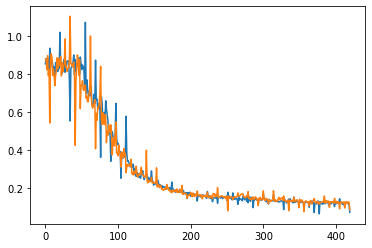

In [304]:
plt.plot(history_train_loss)
plt.plot(history_val_loss)

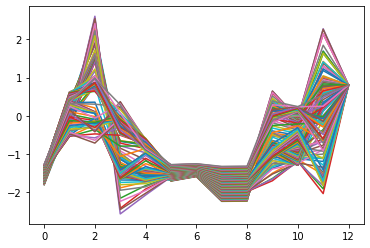

In [305]:
plt.plot(train_dataset[0].detach().numpy())

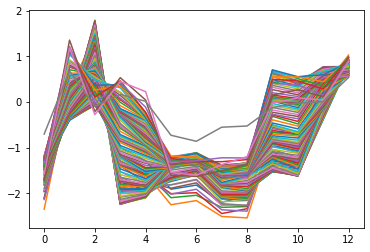

In [306]:
plt.plot(ae(train_dataset[0:1]).detach().numpy()[0])

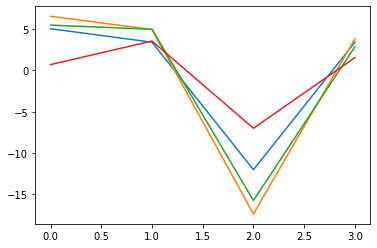

In [307]:
plt.plot(ae.code.detach().numpy()[0])

In [331]:
def reconstruction_loss(generated, original, mode='mean'):
    if mode == 'mean':
        return np.mean((generated.detach().numpy() - original.detach().numpy())**2, axis=(2))
    elif mode == 'max':
        return np.max((generated.detach().numpy() - original.detach().numpy())**2, axis=(2))

In [333]:
reconstructed = ae(train_dataset[:])
reconstruction_error = reconstruction_loss(reconstructed, train_dataset[:])

In [334]:
faulty_dataset = TimeSeriesDataSet("~/Downloads/simu_Elbas/7h33D1/7hnz0038.xls",
                            lookback=lookback,
                            features=features,
                            feature_to_reconstruct='voltage [V]')

In [335]:
reconstructed = ae(faulty_dataset[:])
abnormal_reconstruction_error = reconstruction_loss(reconstructed, faulty_dataset[:])

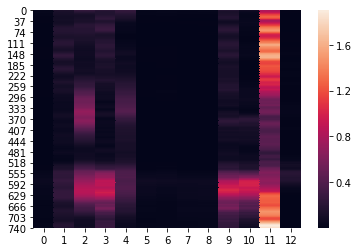

In [337]:
sns.heatmap(abnormal_reconstruction_error)


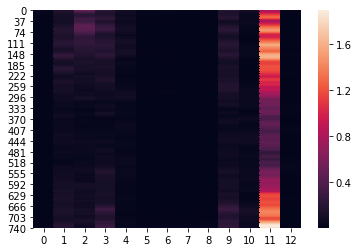

In [336]:
sns.heatmap(reconstruction_error)

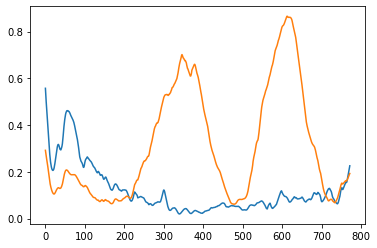

In [339]:
plt.plot(reconstruction_error[:,2])
plt.plot(abnormal_reconstruction_error[:,2])

In [341]:
ae


AE(
  (encoder): Encoder(
    (conv1): Conv1d(13, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (layers): ModuleList(
      (0): Conv1d(128, 64, kernel_size=(3,), stride=(2,), padding=(2,), dilation=(2,))
      (1): Conv1d(64, 32, kernel_size=(3,), stride=(2,), padding=(4,), dilation=(4,))
      (2): Conv1d(32, 16, kernel_size=(3,), stride=(2,), padding=(8,), dilation=(8,))
      (3): Conv1d(16, 8, kernel_size=(3,), stride=(2,), padding=(16,), dilation=(16,))
      (4): Conv1d(8, 4, kernel_size=(3,), stride=(2,), padding=(32,), dilation=(32,))
    )
    (activation): ReLU()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): ConvTranspose1d(4, 8, kernel_size=(4,), stride=(1,))
      (1): ConvTranspose1d(8, 16, kernel_size=(8,), stride=(1,))
      (2): ConvTranspose1d(16, 32, kernel_size=(16,), stride=(1,))
      (3): ConvTranspose1d(32, 64, kernel_size=(32,), stride=(1,))
      (4): ConvTranspose1d(64, 128, kernel_size=(64,), stride=(1,))
    )
    (conv6): ConvTrans